# Imports

Import necessary libraries and modules including:
| Libraries | Version | Channel |
| ----------- | ----------- | ----------- |
| Matplotlib | 3.9.1 | conda-forge |
| NumPy | 2.2.2 | conda-forge |
| Matplotlib | 3.9.1 | conda-forge |
| Pandas | 2.2.3 | conda-forge |
| Pillow | 9.4.0 | conda-forge |
| Pytorch | 2.5.1 | conda-forge |
| Seaborn | 0.13.2 | conda-forge |
| Sklearn | 1.6.1 | conda-forge |

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


# Variables

For the sake of simpleness, the essentail constants are listed down below.

In [76]:
# Torch seed (for reproducibility purpose)
SEED = 33

In [77]:
# Dataset paths
base_dir = "faces_dataset"

dataset_dir = os.path.join(base_dir, "dataset", "dataset", "test")

test_dir_real = os.path.join(dataset_dir, "0")
test_dir_fake = os.path.join(dataset_dir, "1")

In [78]:
# # Dataset paths
# base_dir = "cropped_faces_dataset"

# dataset_dir = base_dir

# test_dir_real = os.path.join(dataset_dir, "human")
# test_dir_fake = os.path.join(dataset_dir, "AI")

In [79]:
# Training varaibles
BATCH_SIZE = 64 # Number of images per batch
NUM_WORKERS = 12 # Number of CPU cores used for dataloader

# Image information
image_info = {
    # Both width and height are usually equal
    "width": 256,
    "height": 256
}

# Training data labels map
labels_map = {
    0: "Human",
    1: "AI"
}

In [80]:
# Display variables
display_figure_info = {
    "width": 12,
    "height": 12,
    "row": 3,
    "column": 3
}

In [81]:
# Current model
model_version = "best"

def get_current_model_path(new_model=False):
    count = 1

    while (True):
        if (os.path.isfile("../../trained_models/image_simplified_fire_model_" + f"{count}" + "_" + model_version + ".pth") == False):
            if (new_model):
                return "../../trained_models/image_simplified_fire_model_" + f"{count}" + "_" + model_version + ".pth"
            else:
                return "../../trained_models/image_simplified_fire_model_" + f"{count - 1}" + "_" + model_version + ".pth"
        else:
            count += 1

# Data Preprocessing

TODO: methods

In [82]:
torch.cuda.empty_cache() # Free CUDA cache memory
torch.manual_seed(SEED) # Assign Pytorch seed for reproducibility

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Initiate a CUDA device instance, if exists

In [83]:
test_fake_faces_path = [os.path.join(test_dir_fake, file) for file in os.listdir(test_dir_fake) if file.endswith(".jpg")]
test_real_faces_path = [os.path.join(test_dir_real, file) for file in os.listdir(test_dir_real) if file.endswith(".jpg")]

In [84]:
print(len(test_fake_faces_path))
print(len(test_real_faces_path))

10190
11070


In [85]:
test_path = test_fake_faces_path + test_real_faces_path
test_path_df = pd.DataFrame(test_path, columns=["id"])

In [86]:
test_path_df

,id
0,faces_dataset/dataset/dataset/test/1/ff3b28971...
1,faces_dataset/dataset/dataset/test/1/5859b50b3...
2,faces_dataset/dataset/dataset/test/1/fbd6c2802...
3,faces_dataset/dataset/dataset/test/1/3acd04a61...
4,faces_dataset/dataset/dataset/test/1/cc15efdd6...
...,...
21255,faces_dataset/dataset/dataset/test/0/14019.jpg
21256,faces_dataset/dataset/dataset/test/0/23959.jpg
21257,faces_dataset/dataset/dataset/test/0/22573.jpg
21258,faces_dataset/dataset/dataset/test/0/24491.jpg


In [87]:
# Get training labels
test_labels = []

for i in test_fake_faces_path:
    test_labels.append(1)
for i in test_real_faces_path:
    test_labels.append(0)

# Convert list to Pandas dataframe
test_labels_df = pd.DataFrame({'label': test_labels})

# # Get testing labels
# val_labels = []

# for i in train_fake_faces_path:
#     val_labels.append(1)
# for i in train_real_faces_path:
#     val_labels.append(0)

# # Convert list to Pandas dataframe
# val_labels_df = pd.DataFrame({'label':val_labels})

In [88]:
test_labels_df = pd.concat([test_path_df, test_labels_df], axis=1)

In [89]:
test_labels_df

,id,label
0,faces_dataset/dataset/dataset/test/1/ff3b28971...,1
1,faces_dataset/dataset/dataset/test/1/5859b50b3...,1
2,faces_dataset/dataset/dataset/test/1/fbd6c2802...,1
3,faces_dataset/dataset/dataset/test/1/3acd04a61...,1
4,faces_dataset/dataset/dataset/test/1/cc15efdd6...,1
...,...,...
21255,faces_dataset/dataset/dataset/test/0/14019.jpg,0
21256,faces_dataset/dataset/dataset/test/0/23959.jpg,0
21257,faces_dataset/dataset/dataset/test/0/22573.jpg,0
21258,faces_dataset/dataset/dataset/test/0/24491.jpg,0


In [90]:
#  Evaluate the training labels
count = 0

for i in range(len(test_labels)):
    if (test_labels[i] == 1):
        count = count+1

print(test_labels)
print("Number of total labels:", len(test_labels))
print("Number of fake faces samples:", count)
print("Number of real faces samples:", len(test_labels) - count)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [91]:
# Training augmentations
train_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to match ConvNeXt preprocessing
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms
val_test_transforms = transforms.Compose([
    transforms.Resize(232),  # Resize to 232 as per ConvNeXt documentation
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [92]:
# Dataset class for training and validation
class CustomTrainImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        return image, label

# Dataset class for inference (validation and test)
class CustomTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

In [93]:
# Create datasets
# For testing, create a list of file paths (id)
test_file_list = test_labels_df["id"]
test_dataset = CustomTestImageDataset(file_list=test_file_list, transform=val_test_transforms)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [94]:
# Display datasets' information
print(f"Test dataset size: {len(test_dataset)}")

Test dataset size: 21260


# Evaluating the Model

Evaluate and visualize the trained model's performance using validation set.

In [95]:
current_model_path = get_current_model_path()

In [96]:
class FrequencyFilter(nn.Module):
    def __init__(self, radiuslow=40, radiushigh=120):
        super(FrequencyFilter, self).__init__()
        self.radiuslow = radiuslow
        self.radiushigh = radiushigh
        
    def forward(self, image):
        # FFT transform
        freq_image = torch.fft.fftn(image, dim=(-2, -1))
        freq_image = torch.fft.fftshift(freq_image, dim=(-2, -1))
        
        # Create band-pass filters for mid-frequencies
        b, c, h, w = freq_image.shape
        y_grid, x_grid = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
        y_grid = y_grid.to(freq_image.device)
        x_grid = x_grid.to(freq_image.device)
        
        center_y, center_x = h // 2, w // 2
        dist_from_center = torch.sqrt((y_grid - center_y)**2 + (x_grid - center_x)**2)
        
        # Mid-frequency mask
        mid_mask = torch.zeros((h, w), device=freq_image.device)
        mid_mask[(dist_from_center >= self.radiuslow) & (dist_from_center < self.radiushigh)] = 1
        
        # Apply masks
        mid_freq = freq_image * mid_mask.unsqueeze(0).unsqueeze(0)
        
        # Inverse FFT
        mid_freq = torch.fft.ifftshift(mid_freq, dim=(-2, -1))
        mid_freq_spatial = torch.abs(torch.fft.ifftn(mid_freq, dim=(-2, -1)))
        
        # Normalize
        mid_freq_spatial = (mid_freq_spatial - mid_freq_spatial.min() + 1e-8) / (mid_freq_spatial.max() - mid_freq_spatial.min() + 1e-8)
        
        return mid_freq_spatial

In [97]:
class SimplifiedFIRE(nn.Module):
    def __init__(self, pretrained=True):
        super(SimplifiedFIRE, self).__init__()
        # Use a lighter backbone
        self.backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        
        # Modify for input with 6 channels (3 original + 3 frequency)
        original_weight = self.backbone.conv1.weight.clone()
        self.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize with the pretrained weights, duplicated for additional channels
        if pretrained:
            with torch.no_grad():
                self.backbone.conv1.weight[:, :3] = original_weight
                self.backbone.conv1.weight[:, 3:] = original_weight
        
        # Replace classifier
        self.backbone.fc = nn.Linear(512, 1)
        
        # Frequency transform component
        self.freq_filter = FrequencyFilter(radiuslow=30, radiushigh=100)
        
    def forward(self, x):
        # Get mid-frequency features
        mid_freq_image = self.freq_filter(x)
        
        # Use original image and frequency features
        combined_features = torch.cat([x, mid_freq_image], dim=1)
        
        # Pass through backbone
        out = self.backbone(combined_features)
        
        return out

In [98]:
model = SimplifiedFIRE(pretrained=True).to(device)

# Load model
model.load_state_dict(torch.load(current_model_path)) # load the trained model
model = model.to(device)

/tmp/ipykernel_46940/1929579571.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(current_model_path)) # load the trained model


In [99]:
correct = 0 # number of correct predictions
total = 0 # number of total predictions

In [100]:
def load_image(image_path):
    image = Image.open(image_path)
    image = val_test_transforms(image)
    image = image.unsqueeze(0)

    return image.to(device)

In [101]:
test_image_paths = [
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00000.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00008.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00012.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/0/00018.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a0d9a2231dd4b0f9a28c4f4ac78470dc6409dc0.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5af1379a6b932e643d9d5425fb623b87b536066d1ac5b9a70275fcaea6eea8.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a5e9e47b708863223f4b311577bed17e3ff2a25fcb9505874e2866dfaa2af61.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a6c04db17d4cdcce137708101916be457b01c071f47c3aa985c190b6bf05abb.jpg",
    "/home/pooh/coding/AI_vs_human_generated_content_models/src/image/faces_dataset/dataset/dataset/test/1/0a9ebf06a0f94453cf741f6724677968804eb1d2a2466bfb50eca9491869f544.jpg",
]

images = [load_image(img) for img in test_image_paths]

In [102]:
model.eval()
prediction_labels = []

with torch.no_grad():
    for img in images:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prediction_labels.append(predicted.item())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9306722..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.395

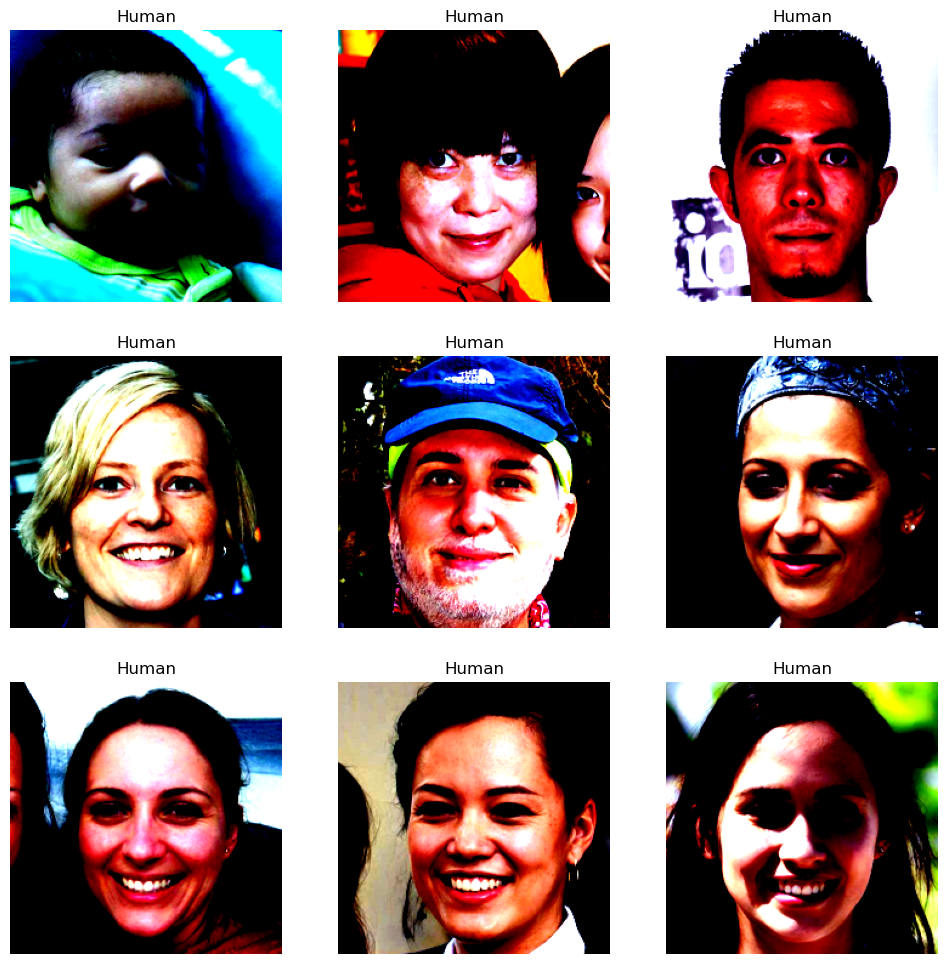

In [103]:
figure = plt.figure(figsize=(display_figure_info["width"], display_figure_info["height"]))

for i in range(1, display_figure_info["row"] * display_figure_info["column"] + 1):
    image_index = (i - 1) % len(images)
    image = images[image_index].cpu().squeeze(0).permute(1, 2, 0)
    label = prediction_labels[image_index]

    figure.add_subplot(display_figure_info["row"], display_figure_info["column"], i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(image)

plt.show()

In [104]:
# Test section using DataLoader
torch.cuda.empty_cache() # Free CUDA cache memory

model.eval() # Set model to evaluation mode

all_labels = [] # Reset labels list for evaluation
all_preds = [] # Reset predictions list for evaluation

print("Starting test set evaluation...")

# --- Create a mapping from filename basename to label for quick lookup ---
# Apply os.path.basename to the entire 'id' column once
test_basenames = test_labels_df['id'].apply(os.path.basename)
# Create a Series where index is the basename and value is the label
basename_to_label_map = pd.Series(test_labels_df['label'].values, index=test_basenames)
# --- End of mapping creation ---


with torch.no_grad(): # Disable gradient calculation
    # Iterate through the test DataLoader
    # test_loader yields batches of (image_tensor, file_name - which is basename)
    for images_batch, file_names_batch in tqdm(test_loader, desc="Evaluating Test Set"):
        images_batch = images_batch.to(device)

        # Get model predictions for the batch
        outputs = model(images_batch)
        _, predicted_batch = torch.max(outputs, 1) # Get the index of the max log-probability

        # Get the true labels for this batch using the basename map
        true_labels_batch = [
            basename_to_label_map[fn] # Use the map with the basename from the loader
            for fn in file_names_batch
        ]

        # Append batch results to the overall lists
        all_labels.extend(true_labels_batch)
        all_preds.extend(predicted_batch.cpu().numpy()) # Move predictions back to CPU and convert to numpy

print(f"Finished evaluation. Collected {len(all_labels)} true labels and {len(all_preds)} predictions.")


Starting test set evaluation...


Evaluating Test Set: 100%|██████████| 333/333 [00:21<00:00, 15.57it/s]

Finished evaluation. Collected 21260 true labels and 21260 predictions.


In [105]:
print(f"Number of true labels: {len(all_labels)}")
print(f"Number of predictions: {len(all_preds)}")

Number of true labels: 21260
Number of predictions: 21260


/home/pooh/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pooh/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pooh/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report:
               precision    recall  f1-score   support

       Human       0.52      1.00      0.68     11070
          AI       0.00      0.00      0.00     10190

    accuracy                           0.52     21260
   macro avg       0.26      0.50      0.34     21260
weighted avg       0.27      0.52      0.36     21260



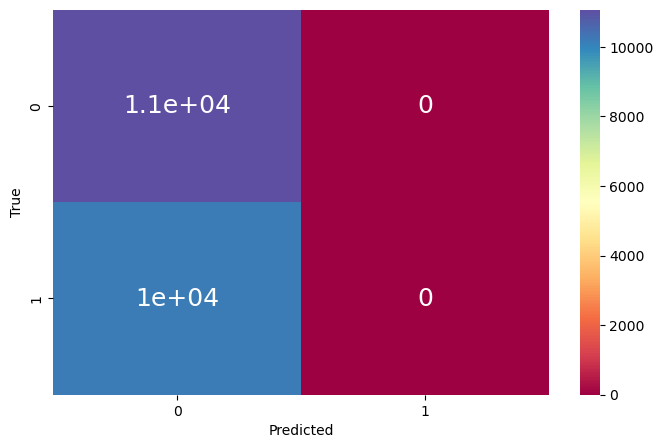

In [106]:
# Classification report
train_report = classification_report(all_labels, all_preds, target_names=[labels_map[i] for i in labels_map])

print("Classification Report:\n", train_report)

# Confusion matrix
cf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 18}, cmap="Spectral")
plt.ylabel('True')
plt.xlabel('Predicted')

count = 1

while (True):
    if (os.path.isfile("../../trained_models/image_simplified_fire_model_" + f"{count}" + "_" + model_version + ".pth") == False):
        plt.savefig("../../src/image/graphs/test_image_faces_fire_model_" + f"{count - 1}" + "_" + model_version + "_classification_report.png") # Save the graph
        break
    else:
        count += 1

plt.show()